#  **EfficientNet**
EfficientNet, first introduced in Tan and Le, 2019 is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to MnasNet, which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (compound-scaling, details see Tan and Le, 2019) allows the efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available at here, where various augmentation schemes and semi-supervised learning approaches are applied to further improve the imagenet performance of the models. These extensions of the model can be used by updating weights without changing model architecture.



# **Dataset & Description**



[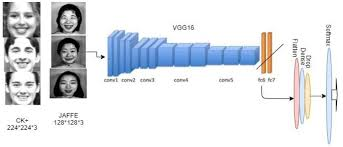](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [15]:
directory=r'F:\it18021\archive\train'
train_dataset  = train_datagen.flow_from_directory(directory =r'F:\it18021\archive\train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [16]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'F:\it18021\archive\train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [17]:
test_dataset = test_datagen.flow_from_directory(directory = r'F:\it18021\archive\test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [22]:
from tensorflow.keras.preprocessing import image
img = image.load_img(r'F:\it18021\archive\train\PrivateTest_10131363.jpg',target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [28]:
import os 
from tensorflow.keras.preprocessing import image
img = image.load_img(os.path.join('F:\it18021\archive\test\PrivateTest_10131363.jpg'),target_size=(48,48))


OSError: [Errno 22] Invalid argument: 'F:\\it18021\x07rchive\test\\PrivateTest_10131363.jpg'

In [20]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(48,48,3),include_top=False,weights="imagenet")

16711680/16705208 [==============================] - 3s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5120)              20480     
_________________________________________________________________
dense (Dense)                (None, 32)                163872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

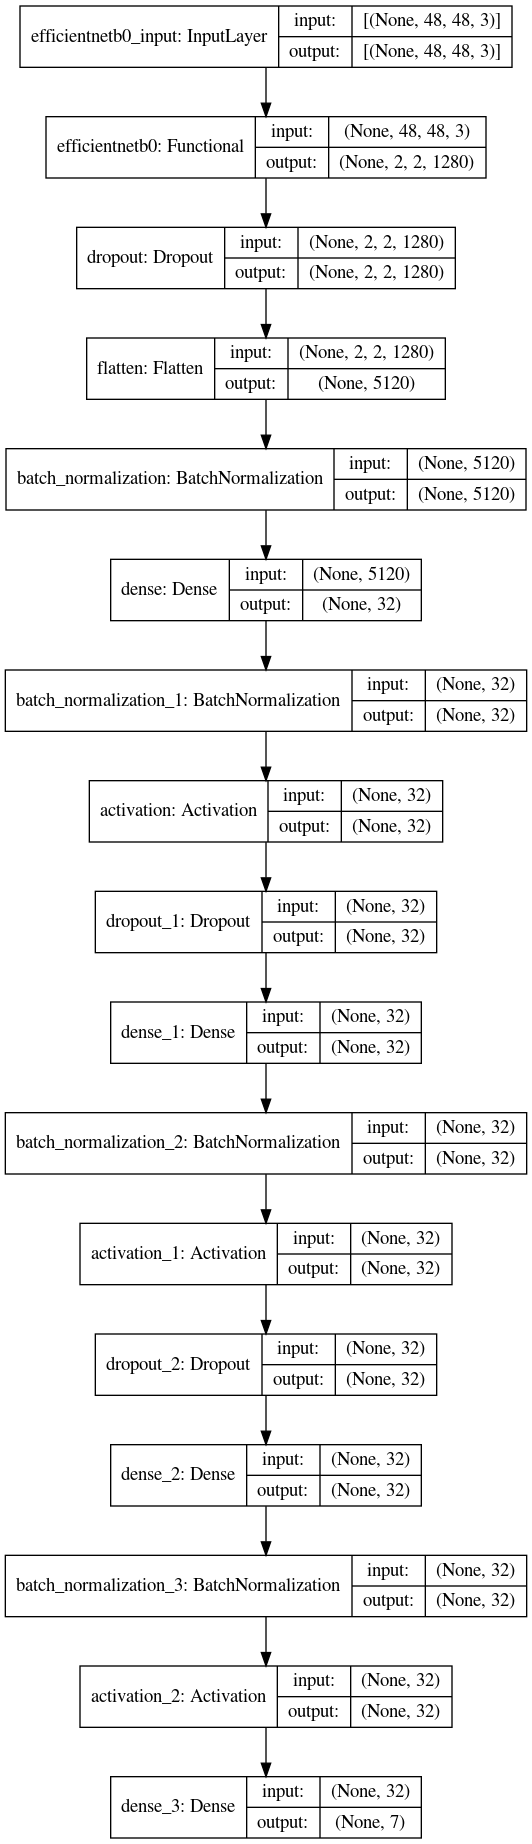

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [16]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 50,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/50
359/359 [==============================] - 209s 559ms/step - loss: 2.0189 - accuracy: 0.8528 - precision: 0.2034 - recall: 0.0106 - auc: 0.5784 - f1_score: 0.0195 - val_loss: 1.8342 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6396 - val_f1_score: 0.0000e+00
Epoch 2/50
359/359 [==============================] - 97s 270ms/step - loss: 1.8474 - accuracy: 0.8569 - precision: 0.2688 - recall: 0.0011 - auc: 0.6253 - f1_score: 0.0022 - val_loss: 1.8157 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6429 - val_f1_score: 0.0000e+00
Epoch 3/50
359/359 [==============================] - 96s 268ms/step - loss: 1.8299 - accuracy: 0.8571 - precision: 0.3179 - recall: 5.1348e-04 - auc: 0.6352 - f1_score: 0.0010 - val_loss: 1.8126 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6426 - val_f1_score: 0.0000e+00
Epoch 4/50
359/359 [==============================] - 96

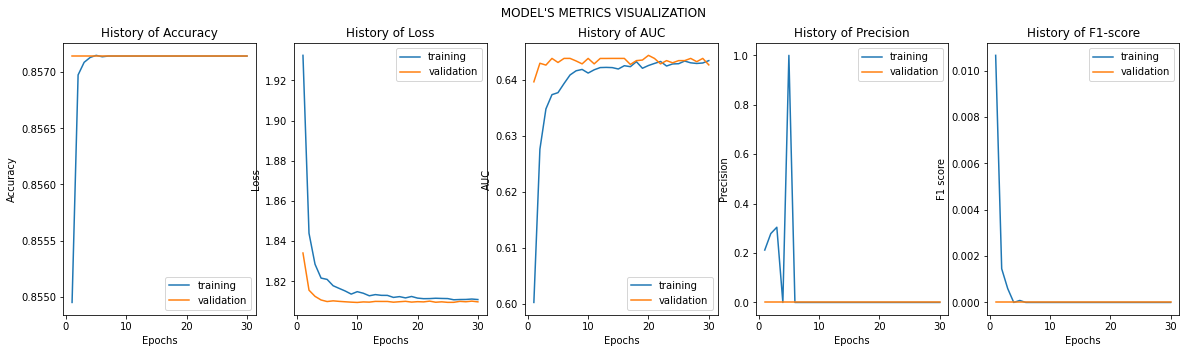

In [17]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )